In [1]:
import pathlib
import scipy.constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fytok.Tokamak import Tokamak
from fytok.modules.CoreProfiles import CoreProfiles
from fytok.modules.Equilibrium import Equilibrium
from spdm.view import View as sp_view
from spdm.data.Path import Path
from spdm.data.Function import Function

data_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

astra_profiles = pd.read_excel(
    next(data_path.glob("*ASTRA.xls")).absolute().as_posix(), sheet_name=1, header=10, usecols="B:BN"
)

2024-01-08 18:50:26,486 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2024-01-08T18:50:26.338407.
 Job ID: fytok_salmon_surface_8642

###################################################################################################



In [2]:
core_profiles_astra = CoreProfiles(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}#core_profiles"
)

core_profiles_1d_astra = core_profiles_astra.time_slice.current.profiles_1d

equilibrium_astra = Equilibrium(f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}#equilibrium")


2024-01-08 18:50:26,879 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2024-01-08 18:50:26,952 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-01-08 18:50:27,018 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2024-01-08 18:50:27,020 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk
2024-01-08 18:50:27,047 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.fy_eq-FyTok 


In [3]:
core_profiles_1d_astra.ion["D"].label

'D'

In [4]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    equilibrium={"code": {"parameters": {"psi_norm": np.linspace(0.01, 0.999, 64)}}},
    core_transport={
        "model": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fusion", "parameters": {"fusion_reactions": ["D(t,n)alpha"]}}},
            # {"code": {"name": "radiation"}},
            # {"code": {"name": "synchrotron_radiation"}},
            # {"code": {"name": "collisional_equipartition"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                # "bvp_rms_mask": [0.96],
                "hyper_diff": 1.0e-5,
                "max_nodes": 257,
                "bc_tol": 1,
                "verbose": 2,
                "units": {
                    "*/density": 1.0e21,
                    "*/density_flux": 1.0e24,
                    "ion/alpha/density": 1.0e18,
                    "ion/alpha/density_flux": 1.0e21,
                    "*/temperature": 1.0e6,
                    "*/temperature_flux": 1.0e27,
                },
            },
        },
        "ion_thermal": ["D", "T"],
        # "ion_non_thermal": ["alpha", "He"],
        # "impurities": ["Ar", "Be"],
        "boundary_condition_type": {
            # fmt: off
            # psi                          at axis \frac{d\psi}{dx}=0  , at boundary \psi=?
            "psi"                       : 1, 
            # density                      at axis \Gamma_s=0          , at boundary n=?
            "*/density"                 : 1, 
            # temperatur                   at axis \frac{dT}{dx}=0     , at boundary T=?
            "*/temperature"             : 1,
            # fmt: on
        },
    },
)
solver = tokamak.transport_solver

2024-01-08 18:50:27,102 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml
2024-01-08 18:50:27,215 [    spdm]     INFO: Load module fytok.plugins.transport_solver_numerics.fy_trans
2024-01-08 18:50:27,218 [    spdm]     INFO: Initialize module fytok.plugins.transport_solver_numerics.fy_trans 


In [5]:
tokamak.initialize()

2024-01-08 18:50:27,243 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-01-08 18:50:27,251 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 
2024-01-08 18:50:27,261 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2024-01-08 18:50:27,264 [    spdm]     INFO: Initialize module fytok.modules.TF 
2024-01-08 18:50:27,268 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2024-01-08 18:50:27,270 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2024-01-08 18:50:27,283 [    spdm]     INFO: Initialize module fytok.modules.CoreSources 
2024-01-08 18:50:27,294 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.dummy 
2024-01-08 18:50:27,300 [    spdm]     INFO: Initialize module fytok.modules.CoreTransport 
2024-01-08 18:50:27,312 [    spdm]     INFO: Initialize module fytok.plugins.core_transport.model.dummy 
2024-01-08 18:50:27,350 [    spdm]    DEBUG: /home/salmon/workspace/fytok/pyt

In [6]:
solver.refresh(
    time=0.0,
    # fmt:off
    initial_value={
        "psi":0.0,
        "ion/D/density":                    1.0e19,
        "ion/T/density":                    1.0e19,
        "ion/He/density":                   1.0,
        "ion/alpha/density":                1.0,

        "ion/D/temperature":                2.0e3,
        "ion/T/temperature":                2.0e3,
        "ion/He/temperature":               2.0e3,
        "electrons/temperature":            2.0e3,
    },
    boundary_value={
        "ion/D/density":                    1.3e19, 
        "ion/T/density":                    1.3e19, 
        "ion/He/density":                   1.0, 
        "ion/alpha/density":                1.0, 

        "ion/D/temperature":                200,   
        "ion/T/temperature":                200,   
        "ion/He/temperature":               200,   
        "electrons/temperature":            200,   
    },
    # fmt:on
)
solver_1d = tokamak.transport_solver.time_slice.current

2024-01-08 18:50:27,382 [    spdm]     INFO: Load module spdm.mesh.mesh_rectangular
2024-01-08 18:50:27,420 [    spdm]  WARNING: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:131:__init__: Singular values are caused when psi_norm takes values of 0.0 or 1.0.! 0.0 1.0
2024-01-08 18:50:29,184 [    spdm]     INFO: Solve transport equations : psi  ,electrons/temperature  ,ion/D/density  ,ion/D/temperature  ,ion/T/density  ,ion/T/temperature
2024-01-08 18:50:29,186 [    spdm]     INFO: Execute module fytok.plugins.transport_solver_numerics.fy_trans FyTrans
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.67e+01       8.32e-01          128           (254)     
Number of nodes is exceeded after iteration 1. 
Maximum relative residual: 3.67e+01 
Maximum boundary residual: 8.32e-01
2024-01-08 18:50:30,348 [    spdm]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fy_trans/fy_trans.

In [7]:
profiles_1d = tokamak.transport_solver.fetch()

2024-01-08 18:50:30,419 [    spdm]     INFO: Load module spdm.view.view_matplotlib


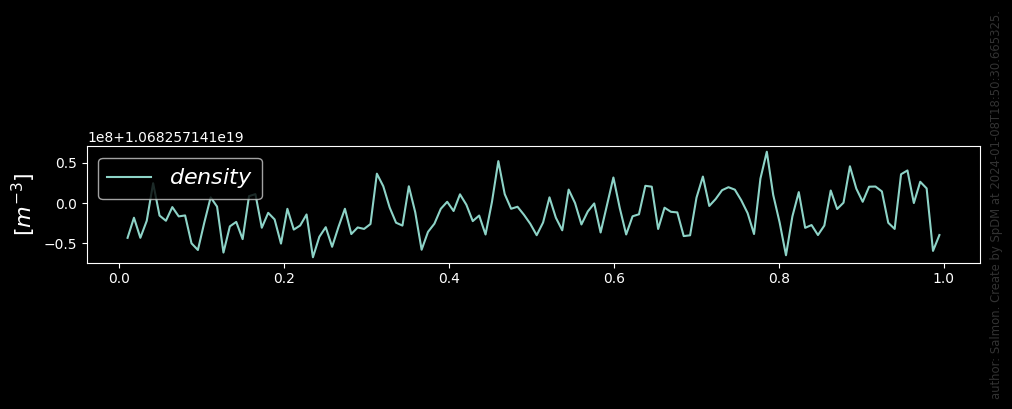

In [8]:
fig=sp_view.plot(profiles_1d.grid.rho_tor_norm, profiles_1d.ion[0].density)

In [9]:
tokamak.flush()

In [10]:
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d

In [11]:
core_profiles_1d_astra.ion._cache

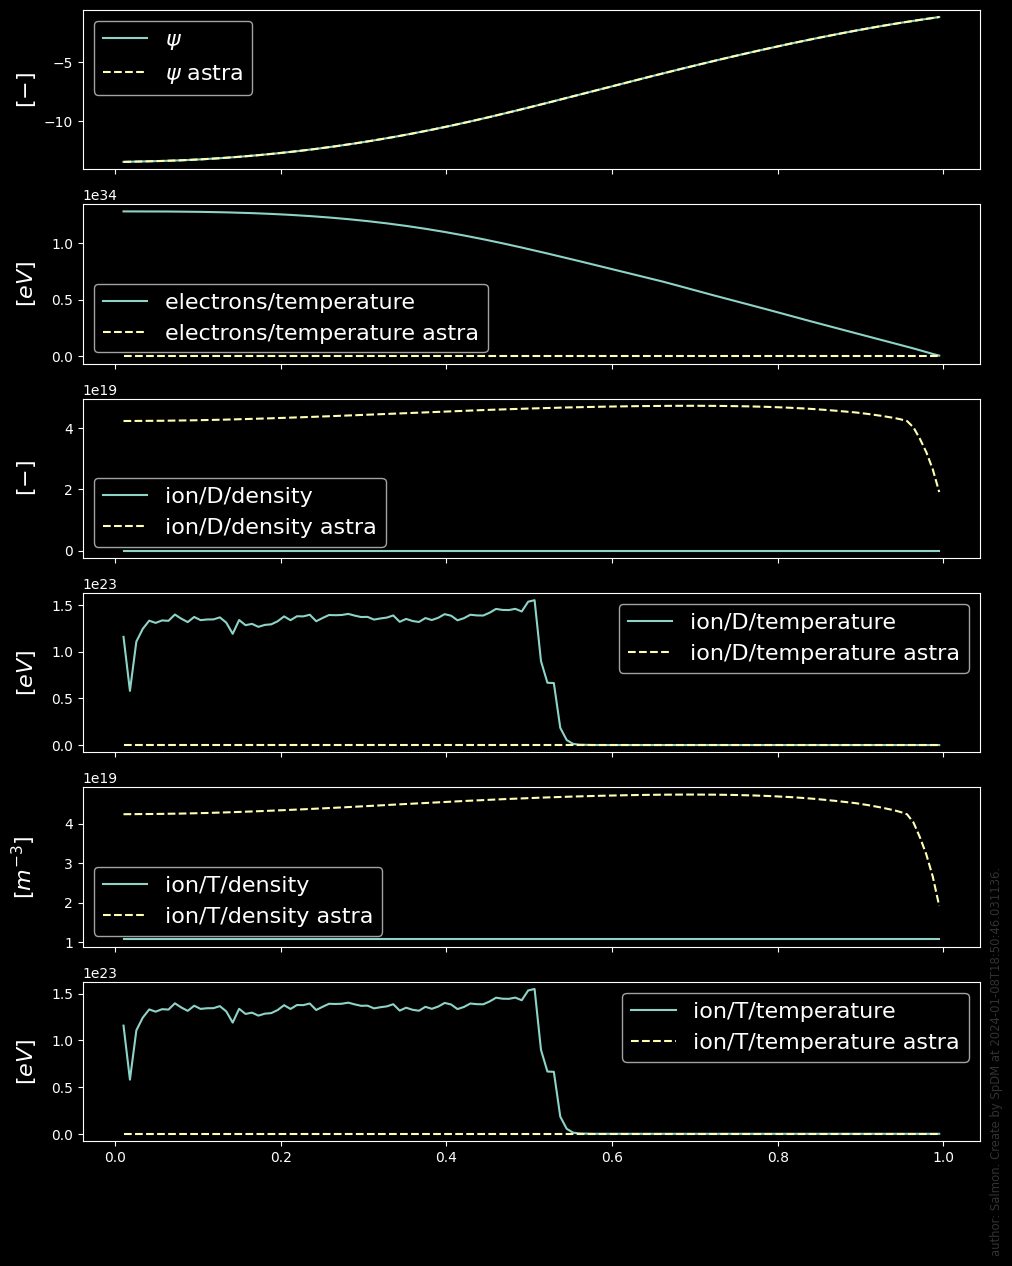

In [14]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.psi, r"$\psi$"),
        (
            equilibrium_astra.time_slice.current.profiles_1d.psi(solver_1d.grid.psi_norm),
            {"label": r"$\psi$ astra", "$matplotlib": {"linestyle": "dashed"}},
        ),
    ],
    *[
        [
            (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} "),
            (
                Path(equ.identifier).get(core_profiles_1d_astra, 0),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for equ in solver_1d.equations
        if equ.identifier != "psi"
    ],
)

In [13]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.ion["alpha"].density, r"$\alpha$"),
        (core_profiles_1d.ion["He"].density, r"He"),
        (core_profiles_1d.ion["He"].density + core_profiles_1d.ion["alpha"].density, r"He+$\alpha$"),
        (core_profiles_1d_astra.ion["He"].density, {"label": f"He astra", "$matplotlib": {"linestyle": "dashed"}}),
    ],
    fontsize=10,
)

AttributeError: 'dict' object has no attribute 'density'

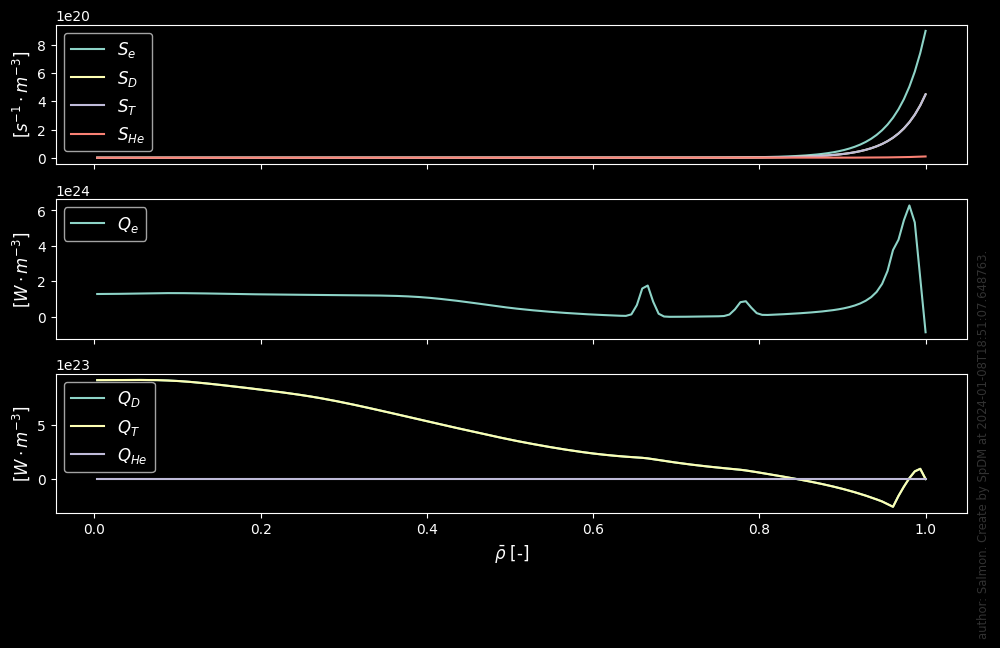

In [15]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")],
    [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [16]:
source_1d = tokamak.core_sources.source[1].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.electrons.temperature, r"$T_{e}$"),
        *[(ion.temperature, rf"$T_{{{ion.label}}}$") for ion in core_profiles_1d.ion],
    ],  # [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [
        (source_1d.electrons.energy, {"label": r"$Q_{e}$", "$matplotlib": {"linestyle": "-", "marker": "."}}),
        *[(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

ModuleNotFoundError: Can not find module as subclass of 'CoreSourcesSource' None from [None] in {'fytok.plugins.transport_solver_numerics.fy_trans': <class 'fytok.plugins.transport_solver_numerics.fy_trans.fy_trans.FyTrans'>}!

In [17]:
astra_rho_tor_norm = astra_profiles["x"].values
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    (
        Function(astra_rho_tor_norm, astra_profiles["Poh"].values * 1.0e6 / scipy.constants.electron_volt),
        r"$Q_{oh}$ astra",
    ),
    [
        (tokamak.core_sources.source[1].time_slice.current.profiles_1d.electrons.energy, r"$Q_{e}$"),
        *[
            (ion.energy, rf"$Q_{{{ion.label}}}$")
            for ion in tokamak.core_sources.source[1].time_slice.current.profiles_1d.ion
        ],
    ],
    [
        (
            Function(astra_rho_tor_norm, astra_profiles["Pdte"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dte}$ astra",
        ),
        (
            Function(astra_rho_tor_norm, astra_profiles["Pdti"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dti}$ astra",
        ),
        (
            Function(astra_rho_tor_norm, (astra_profiles["Pdt"].values) * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dt}$ astra total",
        ),
    ],
    *[
        (
            Function(astra_rho_tor_norm, astra_profiles["Peic"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{e}$ astra",
        ),
        (source_1d.electrons.energy, r"$Q_{e}$"),
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=10,
)

ModuleNotFoundError: Can not find module as subclass of 'CoreSourcesSource' None from [None] in {'fytok.plugins.transport_solver_numerics.fy_trans': <class 'fytok.plugins.transport_solver_numerics.fy_trans.fy_trans.FyTrans'>}!

In [ ]:
source_1d = tokamak.core_sources.source[2].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")],
    [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [ ]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                # (solver_1d.Y0[2 * idx], f"d({equ.identifier})/dr"),
                # (solver_1d.Y0[2 * idx + 1], f"d({equ.identifier}_flux)/dr"),
                (equ.d_dr, f"d({equ.identifier})/dr"),
                (equ.dflux_dr, f"d({equ.identifier}_flux)/dr"),
            ]
            for idx, equ in enumerate(solver_1d.equations)
        ],
        [],
    ),
)

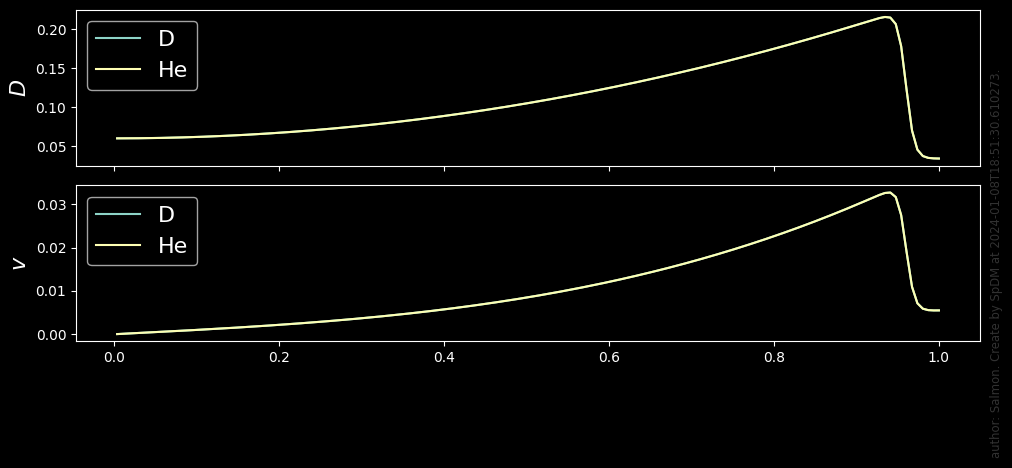

In [18]:
trans_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    trans_1d.grid_d.rho_tor_norm,
    (
        [
            (trans_1d.ion[0].particles.d, trans_1d.ion[0].label),
            (trans_1d.ion[2].particles.d, trans_1d.ion[2].label),
        ],
        {"y_label": "D"},
    ),
    (
        [
            (trans_1d.ion[0].particles.v, trans_1d.ion[0].label),
            (trans_1d.ion[2].particles.v, trans_1d.ion[2].label),
        ],
        {"y_label": "v"},
    ),
)

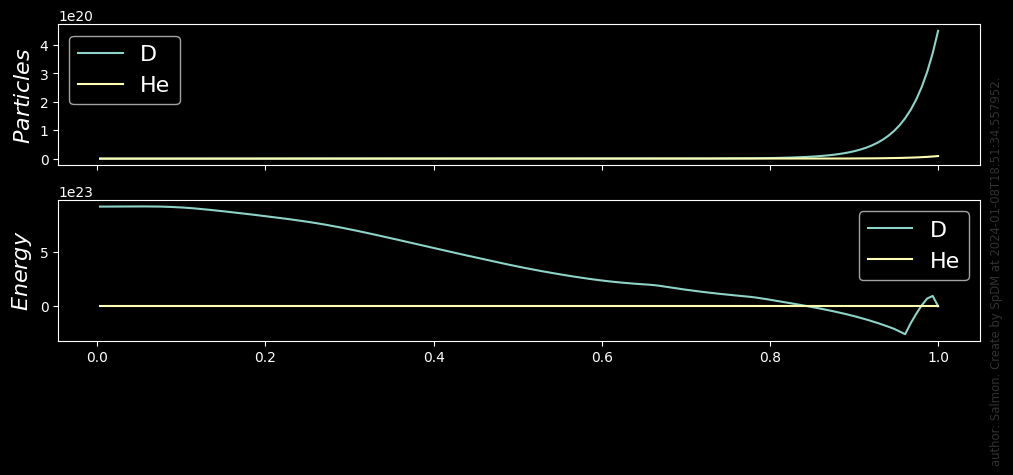

In [19]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    (
        [
            (source_1d.ion[0].particles, source_1d.ion[0].label),
            (source_1d.ion[2].particles, source_1d.ion[2].label),
        ],
        {"y_label": "Particles"},
    ),
    (
        [
            (source_1d.ion[0].energy, source_1d.ion[0].label),
            (source_1d.ion[2].energy, source_1d.ion[2].label),
        ],
        {"y_label": "Energy"},
    ),
)